In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gradio
import os
import pickle
import splitfolders
import math
import shutil
import glob
import keras
import tensorflow as tf
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array , load_img

In [2]:
model = Sequential()

model.add(Conv2D(filters= 16 , kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D())

model.add(Conv2D(filters= 32 , kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D())

model.add(Conv2D(filters= 64 , kernel_size= (3,3), activation= 'relu'))
model.add(MaxPool2D())


model.add(Dropout(rate= 0.25))

model.add(Flatten(input_shape = (224,224,3) ))
model.add(Dense(units=128,activation= 'relu'))
model.add(Dropout(rate= 0.25))
model.add(Dense(units= 3, activation= 'linear'))


# model.summary()

In [3]:
model.compile(optimizer='adam', loss= keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Preparing our data


In [4]:
def preprocessingpretrainedimages(path):
    # input : path 
    # output : pre trained images
    image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, rescale= 1/225, horizontal_flip= True)  #data augmentation
    image = image_data.flow_from_directory(directory= path, target_size= (224,244),batch_size= 64, class_mode= 'binary')

    return image

def preprocessingpretestedimages(path):
    # input : path 
    # output : pre tested images
    image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, rescale= 1/225, horizontal_flip= True) #data augmentation
    image = image_data.flow_from_directory(directory= path, target_size= (224,244),batch_size= 6, class_mode= 'binary')

    return image  

def preProcessingValImages(path):
    # input : path 
    # output : pre tested images
    image_data = ImageDataGenerator(zoom_range= 0.2, shear_range= 0.2, rescale= 1/225, horizontal_flip= True) #data augmentation
    image = image_data.flow_from_directory(directory= path, target_size= (224,244),batch_size= 6, class_mode= 'binary')

    return image 

In [5]:
train_path = "BreastModelData\Train"
test_path = "BreastModelData\Test"
val_path="BreastModelData\Val"

train_data = preprocessingpretrainedimages(train_path)
test_data = preprocessingpretrainedimages(test_path)
val_data = preProcessingValImages(val_path)

Found 529 images belonging to 3 classes.
Found 99 images belonging to 3 classes.
Found 151 images belonging to 3 classes.


In [6]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=6,verbose=1,mode='auto')
mc = ModelCheckpoint(monitor="val_accuracy",filepath="Breast.h5",save_best_only=True,verbose=1,mode='auto') 
cd=[es,mc] 

In [7]:
model_history = model.fit_generator(generator= train_data , epochs= 30, verbose= 1, validation_data= val_data,callbacks= cd )


C:\Users\hamod\AppData\Local\Temp\ipykernel_8820\3559419888.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(generator= train_data , epochs= 30, verbose= 1, validation_data= val_data,callbacks= cd )


Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 2.1133 - accuracy: 0.4178
Epoch 1: val_accuracy improved from -inf to 0.55629, saving model to Breast.h5
9/9 [==============================] - 16s 2s/step - loss: 2.1133 - accuracy: 0.4178 - val_loss: 1.0185 - val_accuracy: 0.5563
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.9392 - accuracy: 0.5936
Epoch 2: val_accuracy did not improve from 0.55629
9/9 [==============================] - 14s 2s/step - loss: 0.9392 - accuracy: 0.5936 - val_loss: 0.9522 - val_accuracy: 0.5563
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.9002 - accuracy: 0.5917
Epoch 3: val_accuracy did not improve from 0.55629
9/9 [==============================] - 15s 2s/step - loss: 0.9002 - accuracy: 0.5917 - val_loss: 0.9585 - val_accuracy: 0.5563
Epoch 4/30
9/9 [==============================] - ETA: 0s - loss: 0.8807 - accuracy: 0.5992
Epoch 4: val_accuracy improved from 0.55629 to 0.56291, saving model t

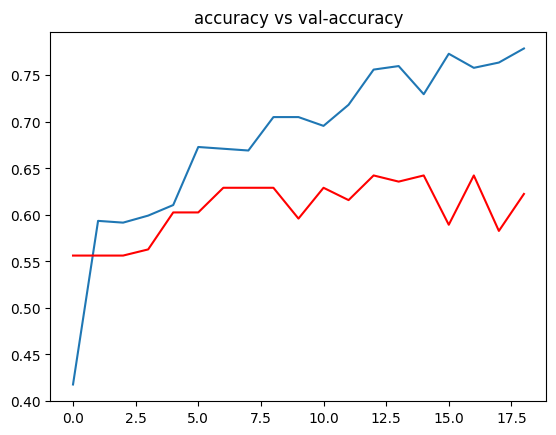

In [8]:
h = model_history.history

plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")

plt.title("accuracy vs val-accuracy")
plt.show()

In [9]:
from keras.models import load_model

acc = model.evaluate(test_data)[1]

print(f"the accuracy of our model is { acc * 100 } % ")

2/2 [==============================] - 2s 655ms/step - loss: 1.0846 - accuracy: 0.5960
the accuracy of our model is 59.59596037864685 % 


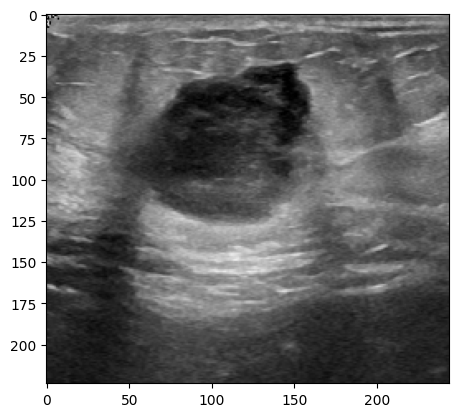

1/1 [==============================] - 0s 120ms/step
this image most likey belong to normal with a 76.97 is percent 


In [10]:
path = "BreastModelData\Test\Malignant\malignant (185).png"

img = load_img(path , target_size= (224,244))
input_arr = img_to_array(img)/255
input_arr = np.expand_dims(input_arr,axis=0)

plt.imshow(img)
plt.show()

class_names = ["normal","benign","malignant"]

pred = model.predict(input_arr)
score = tf.nn.softmax(pred[0])
print("this image most likey belong to {} with a {:.2f} is percent " .format(class_names[np.argmax(score)],100*np.max(score)))






In [11]:
def classify_image(img):
    input_arr = img_to_array(img)/255
    prediction = model.predict(img)
    return {train_data.class_indices[i]: float(prediction[i]) for i in range (2)}


gradio.Interface(fn=classify_image, 
             inputs=gradio.Image(shape=(224, 244)),
             outputs=gradio.Label(num_top_classes=3),
            ).launch(share= True)

Running on local URL:  http://127.0.0.1:7861

Setting up a public link... we have recently upgraded the way public links are generated. If you encounter any problems, please report the issue and downgrade to gradio version 3.13.0
.
Running on public URL: https://d81e2fe5-d7c4-446d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Traceback (most recent call last):
  File "C:\Users\hamod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gradio\routes.py", line 321, in run_predict
    output = await app.blocks.process_api(
  File "C:\Users\hamod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gradio\blocks.py", line 1006, in process_api
    result = await self.call_function(fn_index, inputs, iterator, request)
  File "C:\Users\hamod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gradio\blocks.py", line 847, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "C:\Users\hamod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\anyio\to_thread.py", line 31, in run_sync
    return await get_asynclib().r